<a href="https://colab.research.google.com/github/Arturus/conv_simulator/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование стратегий управления источниками трафика
Демонстрация модели и стратегий, описанных в статье https://suilin.ru/post/conversion_opt/

Для запуска выполните первые две ячейки (Import code & Import libraries), задайте глобальные параметры и выполните ячейку с параметрами. Значения по умолчанию соотвествуют параметрам, с которым запускались стратеги в статье.

После этого можно запускать любую из стратегий. Для работы стратегии Probability Matching будет нужен GPU (GPU Runtime включён по умолчанию)

In [0]:
#@title Import code
!git clone https://github.com/Arturus/conv_simulator.git
!cp -r conv_simulator/consim .
!pip install cupy-cuda92

In [0]:
#@title Import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import numpy as np
from scipy import stats
from scipy.stats import beta, lognorm

from consim.strategy import NaiveStrategy, HalvingStrategy, SoftmaxStrategy, EpsilonDecreasingStrategy, CBRacingStrategy
from consim.prob_matching import ProbMatchingStrategy
from consim.cr_distr import LogNormalConversion, ConstantConversion, RandomDrift
from consim.simulator import Simulator, generate_top_k, proportional_weights

# from tqdm import tnrange


# Параметры

* $simulations$ - количество повторов эксперимента при одном заупске. Чем больше это число, тем точнее результат.
* $N$ - количество источников.
* $V$ - общее количество визитов в день, распределяемое между всеми источниками.
* $T$ - количество дней (продолжительность рекламной кампании).

## Распределение конверсионностей источников
Используется логнормальное распределение $\theta \sim \exp\left(\mathcal{N}(\mu, \sigma^2)\right)$
* $m$ - средняя конверсионность. $\mu=\exp(\ln(m) - \sigma^2 / 2)$
* $\sigma$ - стандатное отклонение логарфима конверсионности
* $w\_max\_avg$ - максимальный вес "среднего" источника, т.е. источника, конверсионность которого равна средней конверсионности $m$. Максимальный вес источника с конверсионностью $\theta$ будет $w\_max\_avg \cdot m/\theta$

## Нестационарность
* $use\_drift$ - использовать нестационарную конверсионность, т.е. в ходе эксперимента она будет изменяться, как geometric gaussian random walk.
* $drift\_\sigma$ - волатильность конверсионности
* $drift\_\eta$ - скорость возврата к среднему

In [0]:
simulations = 2000 #@param {type:"integer"}

N=100 #@param {type:"integer"}
V=100 #@param {type:"integer"}
T=90 #@param {type:"integer"}
#@markdown ## Распределение конверсионностей
m = 0.01134 #@param {type:"number"}
σ = 0.5 #@param {type:"number"}
w_max_avg = 1 #@param {type:"number"}

#@markdown ## Нестационарность
use_drift = False #@param {type:"boolean"}
drift_σ = 0.1 #@param {type:"number"}
drift_η = 0.015 #@param {type:"number"}

cdist = LogNormalConversion.from_mean(m, σ)
# print(cdist.median)
a, b, _, _ = beta.fit(cdist.sample(10000), floc=0, fscale=1)

def plot_distr(distr, label):
    low, high = distr.ppf(0.001), distr.ppf(0.995)
    x = np.linspace(low, high, 200)
    y = distr.pdf(x)
    plt.plot(x, y, label=label)

print(f"Estimated prior parameters: α={a:.2f} β={b:.1f}")
plot_distr(lognorm(s=σ, scale=cdist.median), 'Распределение конверсионности (lognormal)')
plot_distr(beta(a,b), 'Априорное распределение (beta)')

plt.xlabel('Конверсионность')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.legend()

def sample_start_settings(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, ConstantConversion(weights),
                                cdist.mean, mean_max_weight=w_max_avg)


def sample_start_drift(n):
    weights = cdist.sample(n)
    return proportional_weights(weights, 
                                RandomDrift(weights, sigma=drift_sigma, eta=drift_eta),
                                cdist.mean, mean_max_weight=w_max_avg)

initialiser = sample_start_drift if use_drift else sample_start_settings
sim = Simulator(N, V, T, initialiser)

def plot_day_weights(r, days=[0,1,2]):
    norm=colors.PowerNorm(gamma=1/2.5, clip=True, vmin=0)
    #plt.figure(figsize=(s.max_days / 20, 5))
    #plt.figure(figsize=(16, 5))
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(15*.8, 4*.8)
    def plot_weights(ax, day):
        im = ax.imshow(r.day_weights[day]*100, cmap='inferno', norm=norm)
        ax.set_xlabel('День')
        ax.grid(b=False)
        return im
    for i in range(3):
        im = plot_weights(axes[i], days[i])
        if i == 0:
            axes[i].set_ylabel('Номер источника')
    fig.colorbar(im, extend='max', spacing='proportional', label='Вес',
                 shrink=1, format=mtick.PercentFormatter(), ax=axes.ravel().tolist())


def plot_improvement_hist(r):
    def plot_hist(data, label, color):
        kde = stats.gaussian_kde(dataset=data)
        plt.hist(data, bins=20, alpha=0.5, label=label, color=color, density=True);
        data_range = np.linspace(data.min(), data.max())
        plt.plot(data_range, kde.evaluate(data_range), linestyle='-', c=color, lw=2)
        plt.axvline(x=data.mean(),  linestyle='-.', color=color, lw=2)    


    plot_hist(r.total_gain,f"Общее", color="C0") # , $\mu={r.last_gain.mean():3.1f}$%
    plot_hist(r.last_gain, f"Финальное", color="C2")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()
    plt.grid(linestyle=':')
    plt.ylabel("Вероятность")
    plt.title(f"Улучшение,\nраспределение по {len(r.total_gain)} экспериментов")


def boostrap_CI(data, confidence=0.95, n_samples=1000):
    means = np.empty((n_samples, data.shape[1]))
    for i in range(n_samples):
        choices = np.random.randint(0, data.shape[0], size=data.shape[0])
        sample = data[choices]
        mean = sample.mean(axis=0)
        means[i] = mean
    lower_pct = ((1 - confidence) / 2) * 100
    upper_pct = (1 - ((1 - confidence) / 2)) * 100
    result = np.percentile(means, [lower_pct, upper_pct], axis=0)
    return result

def plot_cr_dynamics(r):
    lower, upper = boostrap_CI(r.day_conversion) * 100
    plt.plot(np.array(r.day_conversion).mean(axis=0) * 100, label="Реальная")
    plt.plot(lower, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.plot(upper, linestyle='-', color='C0', lw=1, alpha=.5)
    plt.fill_between(np.arange(len(lower)), lower, upper, color='C0', alpha=.25)
    plt.plot(np.array(r.base_conversion_rate).mean(axis=0) * 100, label="Базовая", linestyle='--')
    plt.plot(np.array(r.ideal_conversion_rate).mean(axis=0) * 100, label="Максимальная", linestyle='--')
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95))
    plt.ylabel('Конверсионность, %')
    plt.xlabel('День');
    plt.title(f'Динамика конверсионности\nУлучшение: {r.total_gain.mean():3.1f}% / {r.last_gain.mean():3.1f}%');
    plt.grid(linestyle=':')
    plt.xlim(0, len(lower)-1);


def plot_profile(r, title=None):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)    
    plot_cr_dynamics(r)
    plt.subplot(1, 2, 2)    
    plot_improvement_hist(r)
    if title:
        plt.suptitle(title)
    plt.tight_layout(w_pad=3)
    print(f"""        Общее улучшение: {r.total_gain.mean():3.1f}%
    Финальное улучшение: {r.last_gain.mean():3.1f}%
    Общая эффективность: {r.total_efficiency.mean():3.1f}%
Финальная эффективность: {r.last_efficiency.mean():3.1f}%""")

def run_simulation(strategy):
    r = sim.run_simulation(simulations, strategy, n_jobs=-1, day_weights=10, progress='console')
    plot_profile(r)
    plot_day_weights(r)


        Общее улучшение: 16.5%
    Финальное улучшение: 28.8%
    Общая эффективность: 48.0%
Финальная эффективность: 55.6%


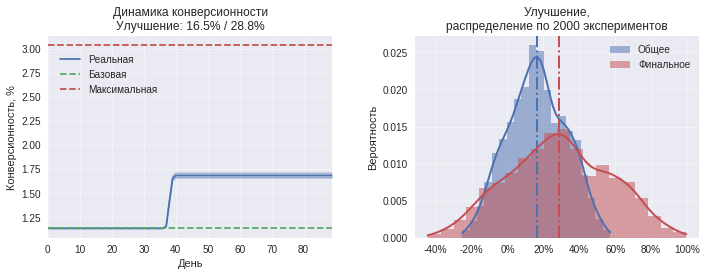

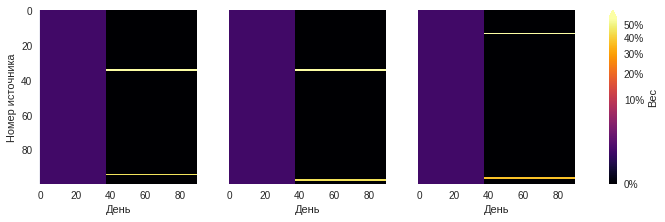

In [25]:
#@title Наивная стратегия
#@markdown Сколько визитов ожидаем до переключения на лучшие источники:
M=38 #@param {type:"integer"}
run_simulation(lambda: NaiveStrategy(M)) 

        Общее улучшение: 34.0%
    Финальное улучшение: 49.7%
    Общая эффективность: 59.0%
Финальная эффективность: 68.8%


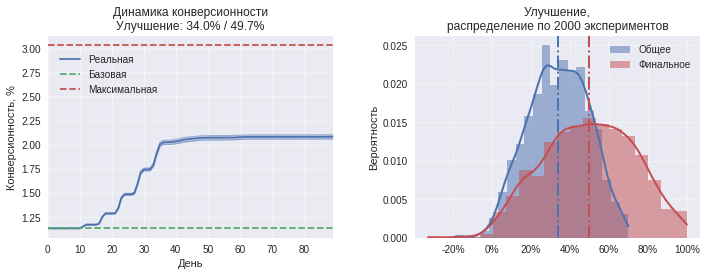

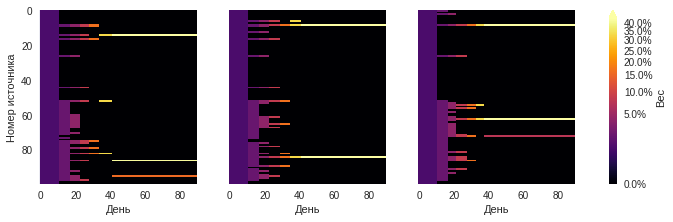

In [26]:
#@title SuccessiveHalving
#@markdown Сколько визитов ожидаем до переключения:
M=11 #@param {type:"integer"}
run_simulation(lambda: HalvingStrategy(M)) 

        Общее улучшение: 37.6%
    Финальное улучшение: 55.1%
    Общая эффективность: 61.2%
Финальная эффективность: 72.1%


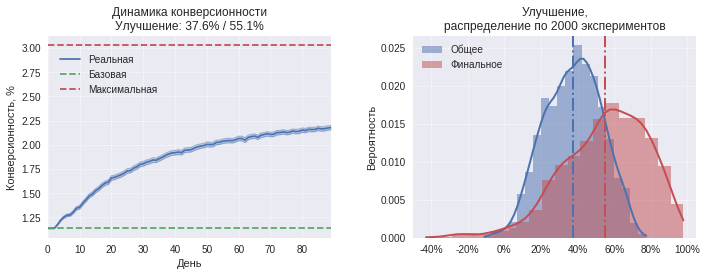

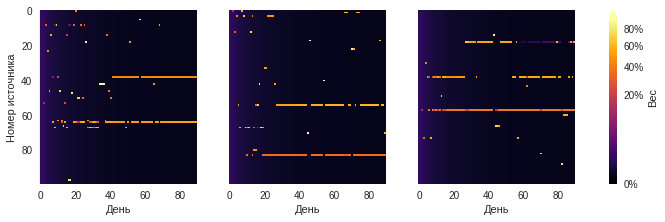

In [27]:
#@title ϵ-decreasing
#@markdown Начальное значение ϵ:
ϵ0=3.5 #@param {type:"number"}
run_simulation(lambda: EpsilonDecreasingStrategy(ϵ0)) 

        Общее улучшение: 38.9%
    Финальное улучшение: 58.7%
    Общая эффективность: 62.0%
Финальная эффективность: 74.3%


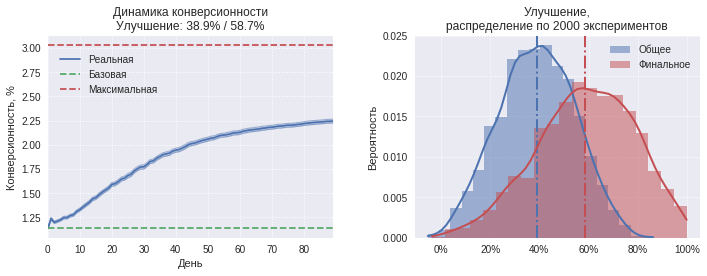

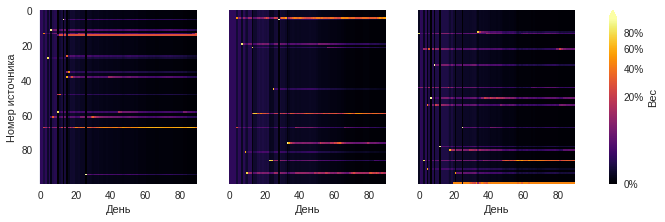

In [30]:
#@title Softmax
#@markdown Начальное значение τ:
τ0=15 #@param {type:"number"}
run_simulation(lambda: SoftmaxStrategy(τ0)) 

        Общее улучшение: 38.8%
    Финальное улучшение: 55.3%
    Общая эффективность: 61.9%
Финальная эффективность: 72.1%


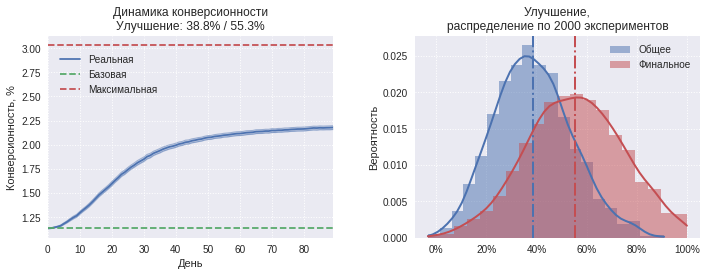

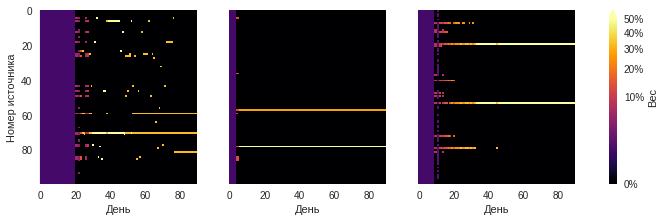

In [31]:
#@title Credible bounds racing
#@markdown Размер правдоподобного интервала в процентах:
credible_interval=32 #@param {type:"number"}
quantile = (1 - credible_interval/100)/2
run_simulation(lambda: CBRacingStrategy(a,b, quantile)) 



        Общее улучшение: 41.1%
    Финальное улучшение: 57.8%
    Общая эффективность: 63.4%
Финальная эффективность: 73.8%


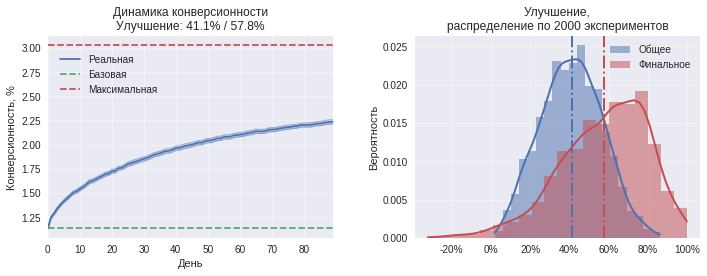

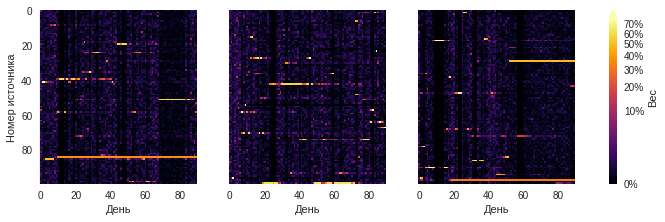

In [6]:
#@title Probability mathcing
#@markdown Жадность:
ρ=7 #@param {type:"number"}
#@markdown Коэффициент затухания (единица, если конверсионность стационарна и затухание не используется):
γ=1 #@param {type:"number"}
#@markdown Количество сэмплов на каждом шаге:
n_samples=2048 #@param {type:"integer"}
run_simulation(lambda: ProbMatchingStrategy(a, b, sample_size=n_samples, power=ρ, sampler='cupy')) 

